In [75]:
# Load Pkgs
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

In [76]:
# Load NLP Pkgs
import spacy
from wordcloud import WordCloud, STOPWORDS
from spacy.util import minibatch, compounding
import matplotlib.pyplot as plt
import re
import random
from spacy.training.example import Example

In [80]:
# Load Dataset
df = pd.read_csv("drug_review_dataset_with_sentiment.csv")
len(df)

161297

In [81]:
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,drug_class,sentiment,sentiment_label
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,arb blocker,0.000000,neutral
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,NaN,0.168333,positive
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,NaN,0.067210,positive
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,NaN,0.179545,positive
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,NaN,0.194444,positive


In [79]:
# NER
nlp0 = spacy.load('en_core_web_sm')

In [6]:
# Get All Components of this NLP Object
nlp0.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [82]:
ner0 = nlp0.get_pipe('ner')

In [83]:
# Example
ex1 = "James went to London to buy Ibuprofen last year 2019"

In [84]:
docx = nlp0(ex1)

In [85]:
type(docx)

spacy.tokens.doc.Doc

In [86]:
# Check for entities
for entity in docx.ents:
    print(entity,entity.label_)

London GPE
Ibuprofen ORG
last year 2019 DATE


### Preparing the data 

Training data must be a tuple

TRAIN_DATA = [ ("Who is Shaka Khan?", {"entities": [(START, STOP, "LABEL")]}) ]


TRAIN_DATA = [ ("Who is Shaka Khan?", {"entities": [(7, 17, "PERSON")]}), ("I like London and Berlin.", {"entities": [(7, 13, "LOC"), (18, 24, "LOC")]}), ]

In [87]:
def process_review(review):
    processed_token = []
    for token in review.split():
        token = ''.join(e.lower() for e in token if e.isalnum())
        processed_token.append(token)
    return ' '.join(processed_token)

In [88]:
# Drugs Names
all_drugs = df['drugName'].unique().tolist()

In [89]:
all_drugs = [x.lower() for x in all_drugs]
all_drugs=="testim"

False

In [90]:
df['review']

0         "It has no side effect, I take it in combinati...
1         "My son is halfway through his fourth week of ...
2         "I used to take another oral contraceptive, wh...
3         "This is my first time using any form of birth...
4         "Suboxone has completely turned my life around...
                                ...                        
161292    "I wrote my first report in Mid-October of 201...
161293    "I was given this in IV before surgey. I immed...
161294    "Limited improvement after 4 months, developed...
161295    "I&#039;ve been on thyroid medication 49 years...
161296    "I&#039;ve had chronic constipation all my adu...
Name: review, Length: 161297, dtype: object

In [91]:
count = 0
TRAIN_DATA = []
for _, item in df.iterrows():
    ent_dict = {}
    if count < 1000:
        review = process_review(item['review'])
        #Locate drugs and their positions once and add to the visited items.
        visited_items = []
        entities = []
        for token in review.split():
            if token in all_drugs:
                for i in re.finditer(token, review):
                    if token not in visited_items:
                        entity = (i.span()[0], i.span()[1], 'DRUG')
                        visited_items.append(token)
                        entities.append(entity)
        if len(entities) > 0:
            ent_dict['entities'] = entities
            train_item = (review, ent_dict)
            TRAIN_DATA.append(train_item)
            count+=1

In [92]:
TRAIN_DATA[1:3]

[('my son is halfway through his fourth week of intuniv we became concerned when he began this last week when he started taking the highest dose he will be on for two days he could hardly get out of bed was very cranky and slept for nearly 8 hours on a drive home from school vacation very unusual for him i called his doctor on monday morning and she said to stick it out a few days see how he did at school and with getting up in the morning the last two days have been problem free he is much more agreeable than ever he is less emotional a good thing less cranky he is remembering all the things he should overall his behavior is better we have tried many different medications and so far this is the most effective',
  {'entities': [(45, 52, 'DRUG')]}),
 ('i used to take another oral contraceptive which had 21 pill cycle and was very happy very light periods max 5 days no other side effects but it contained hormone gestodene which is not available in us so i switched to lybrel because the i

# Training the NER Model

# Model 1

In [98]:
n_iter = 20

def train_ner(training_data):
    """Steps
    Create a Blank NLP  model object
    Create and add NER to the NLP model
    Add Labels from your training data
    Train  
    """
    loss=np.array([])
    TRAIN_DATA = training_data
    nlp = spacy.blank("en")  # create blank Language class
    print("Created blank 'en' model")
    
    if "ner" not in nlp.pipe_names:
        ner = nlp.add_pipe("ner",last=True)
        #nlp.add_pipe(ner, last=True)
    # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")
        
    # add labels
    for _, annotations in TRAIN_DATA:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])
            
    nlp.begin_training()
    for itn in range(n_iter):
        random.shuffle(TRAIN_DATA)
        losses = {}
        # batch up the examples using spaCy's minibatch
        batches = minibatch(TRAIN_DATA, size=compounding(4.0, 32.0, 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            n_samples = len(texts)
            for sample, label in zip(texts[:n_samples],annotations[:n_samples]):

                    example = Example.from_dict(nlp.make_doc(sample), label)
                    nlp.update([example],
                        drop=0.35,  # dropout - make it harder to memorise data
                        losses=losses,
                    )
        print("Losses", losses)
        loss = np.append(loss,losses["ner"])
    return nlp,loss

In [99]:
# Let training
nlp2,loss = train_ner(TRAIN_DATA[:400])

Created blank 'en' model
Losses {'ner': 1476.4693413482346}
Losses {'ner': 621.1470161071356}
Losses {'ner': 460.84652243296495}
Losses {'ner': 408.5085925863318}
Losses {'ner': 354.0274824638392}
Losses {'ner': 305.4900210366631}
Losses {'ner': 281.38367453522454}
Losses {'ner': 275.7851515544002}
Losses {'ner': 228.99135671108903}
Losses {'ner': 192.93567193208636}
Losses {'ner': 177.15371035749666}
Losses {'ner': 180.30321501383457}
Losses {'ner': 156.0389068415934}
Losses {'ner': 131.3795880573382}
Losses {'ner': 135.13311816033192}
Losses {'ner': 133.24631856635796}
Losses {'ner': 124.24139604337125}
Losses {'ner': 95.0174869344701}
Losses {'ner': 87.8327337159944}
Losses {'ner': 75.69145620204382}


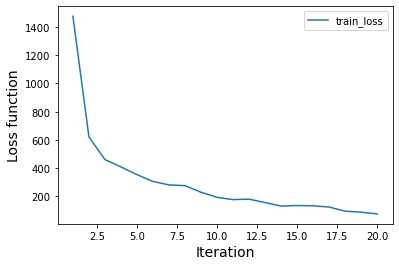

In [100]:
## plot the loss
x=np.arange(1,n_iter+1)
plt.plot(x,loss,label='train_loss')
#plt.plot(x,hist_val,label='val_loss')
plt.xlabel('Iteration',size=14)
plt.ylabel('Loss function',size=14)
plt.legend()
plt.show()

In [101]:
for text,_ in TRAIN_DATA[:2]:
    doc = nlp2(text)
    result = [(ent,ent.label_) for ent in doc.ents]
    print(result)

[(bystolic, 'DRUG')]
[(intuniv, 'DRUG')]


In [102]:
TRAIN_DATA[:1]

[('it has no side effect i take it in combination of bystolic 5 mg and fish oil',
  {'entities': [(50, 58, 'DRUG')]})]

# Model 2

In [103]:
nlp = spacy.load('en_core_web_sm')

In [104]:
n_iter=20
optimizer = nlp.begin_training()
to_train_ents = TRAIN_DATA[:400]
nlp = spacy.load('en_core_web_sm')
los=np.array([])

other_pipes = [pipe for pipe in nlp.pipe_names if pipe !='ner']

with nlp.disable_pipes(*other_pipes): # only train NER
    for itn in range(n_iter): # we are going to go throught the training data 20 times
        losses = {}
        random.shuffle(to_train_ents) # we shuffle the data 
        for item in to_train_ents:
            example = Example.from_dict(nlp.make_doc(item[0]), item[1])
            nlp.update([example],
            sgd=optimizer,
            drop = 0.35,
            losses =  losses)
        #print("Ner",losses["ner"])
        print("Losses", losses)
        los = np.append(los,losses["ner"])
            # this update function Takes 
                       # the model we updated at the begininig at update it with the new information
                       #about the tokens, the position of the tokens and the string.
            

C:\Users\bauri\anaconda3\lib\site-packages\spacy\training\iob_utils.py:141: UserWarning: [W030] Some entities could not be aligned in the text "many people are unreasonably scared of klonopin039..." with entities "[(39, 47, 'DRUG')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\bauri\anaconda3\lib\site-packages\spacy\training\iob_utils.py:141: UserWarning: [W030] Some entities could not be aligned in the text "awful medicine the worst the side effects outweigh..." with entities "[(178, 183, 'DRUG'), (342, 350, 'DRUG')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


Losses {'ner': 898.4494699900418}
Losses {'ner': 570.9510760395482}
Losses {'ner': 434.89532554848273}
Losses {'ner': 361.91761319104893}
Losses {'ner': 299.3772297728937}
Losses {'ner': 276.6390556811748}
Losses {'ner': 221.62571606205822}
Losses {'ner': 202.92119564950963}
Losses {'ner': 165.65638567605615}
Losses {'ner': 148.34504822523007}
Losses {'ner': 129.26997164772527}
Losses {'ner': 113.90289238706552}
Losses {'ner': 94.89393987314004}
Losses {'ner': 115.55680217155803}
Losses {'ner': 97.71490754590407}
Losses {'ner': 98.9155575410243}
Losses {'ner': 89.60194474818019}
Losses {'ner': 74.6387717747956}
Losses {'ner': 54.50974530661432}
Losses {'ner': 64.68038665396445}


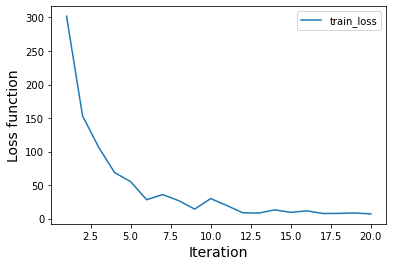

In [69]:
## plot the loss
x=np.arange(1,n_iter+1)
plt.plot(x,los,label='train_loss')
#plt.plot(x,hist_val,label='val_loss')
plt.xlabel('Iteration',size=14)
plt.ylabel('Loss function',size=14)
plt.legend()
plt.show()

In [70]:
for text,_ in TRAIN_DATA[:1]:
    doc = nlp(text)
    result = [(ent,ent.label_) for ent in doc.ents]
    print(result)

[(bystolic, 'DRUG')]


In [57]:
TRAIN_DATA[:1]

[('it has no side effect i take it in combination of bystolic 5 mg and fish oil',
  {'entities': [(50, 58, 'DRUG')]})]

## Loss for the two model

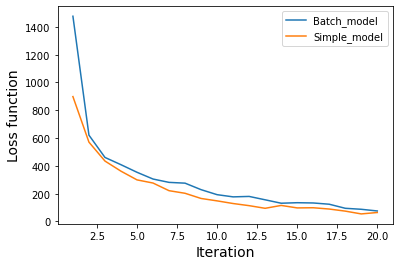

In [108]:
## plot the loss
x=np.arange(1,n_iter+1)
plt.plot(x,loss,label='Batch_model')
plt.plot(x,los,label='Simple_model')
plt.xlabel('Iteration',size=14)
plt.ylabel('Loss function',size=14)
plt.legend()
plt.show()

# Extract drug entity 

## Model 1

In [109]:
def extract_drug_entity(text):
    docx =  nlp2(text)
    result = [(ent,ent.label_) for ent in docx.ents]
    return result

In [110]:
df['review'][0:10]

0    "It has no side effect, I take it in combinati...
1    "My son is halfway through his fourth week of ...
2    "I used to take another oral contraceptive, wh...
3    "This is my first time using any form of birth...
4    "Suboxone has completely turned my life around...
5    "2nd day on 5mg started to work with rock hard...
6    "He pulled out, but he cummed a bit in me. I t...
7    "Abilify changed my life. There is hope. I was...
8    " I Ve had  nothing but problems with the Kepp...
9    "I had been on the pill for many years. When m...
Name: review, dtype: object

In [111]:
df['review'][0:10].apply(extract_drug_entity)

0                   [((Bystolic), DRUG), ((Mg), DRUG)]
1                                  [((Intuniv), DRUG)]
2                 [((Lybrel), DRUG), ((Lybrel), DRUG)]
3                                                   []
4                                [((oxycontin), DRUG)]
5                                                   []
6                                                   []
7    [((Zoloft), DRUG), ((Clonidine), DRUG), ((Zolo...
8                                                   []
9                                  [((chateal), DRUG)]
Name: review, dtype: object

## Model 2

In [112]:
def extract_drug_entity_1(text):
    docx =  nlp(text)
    result = [(ent,ent.label_) for ent in docx.ents]
    return result

In [113]:
h = df['review'][0:10].apply(extract_drug_entity_1)

In [117]:
df['review'][0]

'"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"'

In [115]:
h

0                                 [((Bystolic), DRUG)]
1                                  [((Intuniv), DRUG)]
2                                   [((Lybrel), DRUG)]
3                                                   []
4            [((Suboxone), DRUG), ((oxycontin), DRUG)]
5                                                   []
6                                                   []
7    [((Abilify), DRUG), ((Zoloft), DRUG), ((Clonid...
8                                                   []
9                                  [((chateal), DRUG)]
Name: review, dtype: object

# Confusion Matrix for Spacy NER

In [121]:
for item in to_train_ents[:2]:
    example = Example.from_dict(nlp.make_doc(item[0]), item[1])
scorer = nlp.evaluate(Example.from_dict(to_train_ents[0][:2],to_train_ents[1][:2]))

TypeError: Argument 'predicted' has incorrect type (expected spacy.tokens.doc.Doc, got tuple)

## Sample expected (target) values